In [1]:
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense,LSTM,Dropout,Embedding,BatchNormalization
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.datasets import imdb
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
np.random.seed(18)

In [3]:
(X_train,y_train),(X_test,y_test)=tf.keras.datasets.imdb.load_data(num_words=10000)   #vocabulary size=10000

In [4]:
word2id=imdb.get_word_index()                                  #Retrieves a dict mapping words to their index in the IMDB dataset
id2word={i:word for word,i in word2id.items()}

In [5]:
for i in X_train[5]:
    print(i,id2word.get(i,' '),sep=':',end=' ')                
print('\n',y_train[5])                                         #example to show words and their index 

1:the 778:effort 128:still 74:been 12:that 630:usually 163:makes 15:for 4:of 1766:finished 7982:sucking 1051:ended 2:and 32:an 85:because 156:before 45:if 40:just 148:though 139:something 121:know 664:novel 665:female 10:i 10:i 1361:slowly 173:lot 4:of 749:above 2:and 16:with 3804:connect 8:in 4:of 226:script 65:their 12:that 43:out 127:end 24:his 2:and 10:i 10:i 
 0


In [6]:
print('Maximum review length',len(max((X_train+X_test),key=len)))         
print('Minimum review length',len(min((X_train+X_test),key=len)))
review_length=[]
for i in X_train+X_test:
    review_length.append(len(i))
print('Average length of review',sum(review_length)/len(X_train+X_test))  


Maximum review length 2697
Minimum review length 70
Average length of review 469.51784


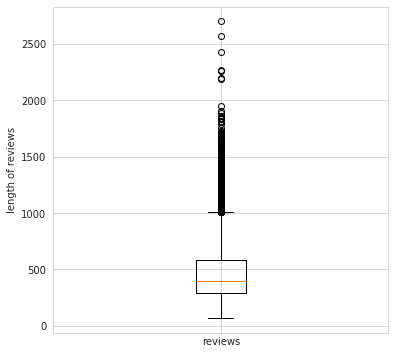

In [8]:
#graphical represtation of length of reviews in dataset
review_length=np.array(review_length)
df=pd.DataFrame(review_length)
sns.set_style("whitegrid")
plt.figure(figsize=(6,6))
plt.boxplot(df[0])
plt.xlabel('reviews')
plt.ylabel('length of reviews')
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

In [9]:
max_review_length=500
X_train=sequence.pad_sequences(X_train, maxlen=max_review_length)
X_test=sequence.pad_sequences(X_test, maxlen=max_review_length)

In [10]:
def create_model():
    model=None
    model=tf.keras.Sequential()
    model.add(Embedding(10000,32,input_length=500))
    model.add(Dropout(0.2))
    model.add(LSTM(100, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(50, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(20))
    model.add(Dense(1,activation='sigmoid'))
    model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
    return model

In [11]:
model=create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 500, 32)           320000    
_________________________________________________________________
dropout (Dropout)            (None, 500, 32)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 500, 100)          53200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 500, 100)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 500, 50)           30200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 500, 50)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 20)                5

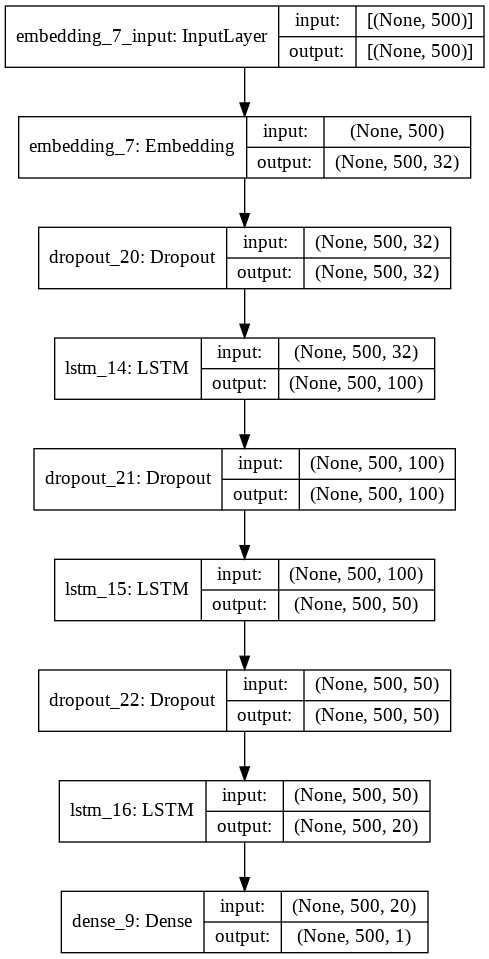

In [108]:
plot_model(model,'/content/drive/MyDrive/ProjectsML/Sentiment Analysis/model.png',show_shapes=True)

In [116]:
filepath = "/content/drive/MyDrive/ProjectsML/Sentiment Analysis/weights-improvement-{epoch:02d}-{val_loss:.2f}.hdf5"

checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss',              #to save the model after every epoch if val loss decrease
                                                 save_best_only=True,
                                                 mode='min',
                                                 verbose=1)
early_stop=EarlyStopping(monitor='val_loss',patience=5,verbose=1)                          #to stop the training early if val loss doesn't decreases from last 5 epoch
                                                 
callback_list=[checkpoint,early_stop]

In [117]:
history=model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=30,batch_size=32,callbacks=callback_list)

Epoch 1/30
782/782 [==============================] - 66s 80ms/step - loss: 0.5608 - accuracy: 0.7010 - val_loss: 0.6588 - val_accuracy: 0.7213

Epoch 00001: val_loss improved from inf to 0.65877, saving model to /content/drive/MyDrive/ProjectsML/Sentiment Analysis/weights-improvement-01-0.66.hdf5
Epoch 2/30
782/782 [==============================] - 62s 79ms/step - loss: 0.6859 - accuracy: 0.5464 - val_loss: 0.4678 - val_accuracy: 0.7903

Epoch 00002: val_loss improved from 0.65877 to 0.46777, saving model to /content/drive/MyDrive/ProjectsML/Sentiment Analysis/weights-improvement-02-0.47.hdf5
Epoch 3/30
782/782 [==============================] - 62s 79ms/step - loss: 0.4287 - accuracy: 0.8106 - val_loss: 0.3277 - val_accuracy: 0.8668

Epoch 00003: val_loss improved from 0.46777 to 0.32768, saving model to /content/drive/MyDrive/ProjectsML/Sentiment Analysis/weights-improvement-03-0.33.hdf5
Epoch 4/30
782/782 [==============================] - 62s 79ms/step - loss: 0.2932 - accuracy: 

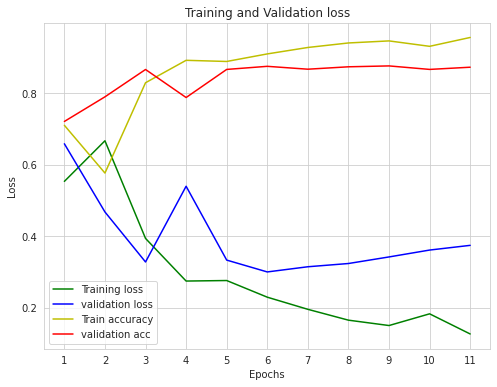

In [118]:
loss_train = history.history['loss']
loss_val = history.history['val_loss']
train_acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
plt.figure(figsize=(8,6))
epochs = range(1,12)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.plot(epochs, train_acc, 'y', label='Train accuracy')
plt.plot(epochs, val_acc, 'r', label='validation acc')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks([i for i in epochs])
plt.legend()
plt.show()

In [12]:
model=load_model('/content/drive/MyDrive/ProjectsML/Sentiment Analysis/weights-improvement-06-0.30.hdf5')

In [13]:
model.save('/content/drive/MyDrive/ProjectsML/Sentiment Analysis/best model.h5')

In [121]:
train_loss,train_acc=model.evaluate(X_train,y_train,batch_size=32)
print('Train loss:',train_loss)
print('Train accuracy:',train_acc)

782/782 [==============================] - 20s 25ms/step - loss: 0.1699 - accuracy: 0.9429
Train loss: 0.16990786790847778
Train accuracy: 0.9428799748420715


In [122]:
test_loss,test_acc=model.evaluate(X_test,y_test,batch_size=32)
print('Test loss:',test_loss)
print('Test accuracy:',test_acc)

782/782 [==============================] - 20s 25ms/step - loss: 0.2998 - accuracy: 0.8757
Test loss: 0.2997978627681732
Test accuracy: 0.8757200241088867


In [147]:
from sklearn.metrics import confusion_matrix, f1_score

In [148]:
con_matrix=confusion_matrix(y_test,y_pred)
con_matrix

array([[10530,  1970],
       [ 1137, 11363]])

In [149]:
print('F1 score:',f1_score(y_test,y_pred))

F1 score: 0.8797274803545851
